<h1>Obiettivi dello studio</h1>

L'obiettivo di questo progetto è il riconoscimento delle diverse tipologie di portieri presenti nei campionati italiano, inglese, francese e spagnolo, sulla base delle statistiche della stagione 20/21 (scaricate dal sito https://fbref.com); applicando la tecnica del clustering, si cercherà di raggruppare i portieri sulla base delle loro statistiche, e quindi delle loro caratteristiche. In questo modo, si potrà consigliare ad una squadra che deve rinunciare al proprio portiere (per esempio per la cessione o la scadenza del contratto) un nuovo portiere con le stesse caratteristiche e lo stesso stile di gioco.
Sarà svolta inoltre un'analisi su più anni (dalla stagione 2017/2018 alla 2020/2021) per individuare i portieri che nel corso delle stagioni hanno cambiato cluster di appartenenza, al fine di riconoscere cambiamenti delle loro caratteristiche.

---------------------------------------------------------

Link alle pagine da cui sono presi i dati:
---------------------------------------------------------------------------------------------------------
- Statistiche Serie A normali ->  https://fbref.com/en/comps/11/keepers/Serie-A-Stats
- Statistiche Serie A Advanced -> https://fbref.com/en/comps/11/keepersadv/Serie-A-Stats#all_stats_keeper_adv

- Statistiche Premier League -> https://fbref.com/en/comps/9/keepers/Premier-League-Stats#all_stats_keeper  
- Statistiche Premier League advanced -> https://fbref.com/en/comps/9/keepersadv/Premier-League-Stats 

- Statistiche Liga Normali -> https://fbref.com/en/comps/12/keepers/La-Liga-Stats#all_stats_keeper
- Statistiche Liga Advanced  -> https://fbref.com/en/comps/12/keepersadv/La-Liga-Stats

- Statistiche Ligue One Normali-> https://fbref.com/en/comps/13/keepers/Ligue-1-Stats#all_stats_keeper
- Statistiche Ligue One Advanced -> https://fbref.com/en/comps/13/keepersadv/Ligue-1-Stats


In [1]:
#basic imports
import numpy as np
from io import StringIO
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.tree import _tree
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

import random

#plotly imports
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


<h2>Metodi di supporto</h2>

Definiamo qualche metodo di utilità che ci servirà successivamente.

In [2]:
#Il metodo serve per plottare i cluster sfruttando la tecnica PCA
def plot_PCA(plotS, num_clusters, num_dim, information):
    colors = ['#0000ff','#000000', '#ffff66', '#00ff00', '#ff0000', '#ff00ff', '#663300', '#ff66ff', '#00ccff']
    
    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)
    
    
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)

    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)

    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)
    
    PCs_1d.columns = ["PC1_1d"]

    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    
    plotS = pd.concat([plotS,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
    plotS["dummy"] = 0
    
    clusters = []
    for i in range(num_clusters):
        clusters.append(plotS[plotS["cluster"] == i])
        
    traces = []
    for i in range(num_clusters):
        if num_dim == 3:
            traces.append(go.Scatter3d(
            x = clusters[i]["PC1_3d"],
            y = clusters[i]["PC2_3d"],
            z = clusters[i]["PC3_3d"],
            mode = "markers",
            name = "Cluster {}".format(i),
            marker = dict(color = colors[i])
                ,text = None)
                         )
        else: 
            traces.append(go.Scatter(
            x = clusters[i]["PC1_2d"],
            y = clusters[i]["PC2_2d"],
            mode = "markers",
            name = "Cluster {}".format(i),
            marker = dict(color = colors[i]),text = None)
                         )
        
    data = traces
    
    title = "Visualizzazione cluster in {} Dimensioni usando PCA, tipo: {}".format(num_dim, information)

    layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

    fig = go.Figure(data = data, layout = layout)

    fig.show(width=100, height=100)



In [3]:
#Il metodo dato un dataframe, permette di rinominare il nome della colonna specificato
#e di modificare solo l'occorrenza specificate
#il numero di occorenza va da 1 a n, con 1 che indica una singola occorrenza (la prima)
def rinomina_occorrenza(col_da, col_a, dataframe, num_occ):
    colonne = dataframe.columns.values
    for col in colonne:
        if (col == col_da) and (num_occ==1):
            #nel caso in cui le colonne duplicate sono esattamente 2, e quindi vado a cambiare il nome alla seconda
            
            #prendo la prima colonna duplicata
            c1 = dataframe[col_da].iloc[:, 0]
            #prendo la seconda colonna duplicata
            c2 = dataframe[col_da].iloc[:, 1]
            
            #droppo entrambe le colonne duplicate
            dataframe.drop(col_da, axis=1, inplace=True)

            #inserisco la vecchia colonna che ho rimosso
            dataframe[col_da] = c1
            #inserisco la seconda colonna a cui dovevo cambiare il nome, con il nuovo nome
            dataframe[col_a] = c2
            
            
            return 
        elif (col == col_da) and (num_occ!=1):
            num_occ -= 1
    

In [4]:
#Il metodo calcola e stampa un line plot in cui è mostrata la variazione negli anni del valore di dimensione ricevuto,
#mostra quindi per ogni anno la media dei 10 valori maggiori/minori, ed il valore medio dei valori di "dimensione".
def cfr_anni(dict_, dimensione):
    cmp_mean = pd.DataFrame()
    
    #prendiamo i valori maggiori delle medie anno per anno
    cmp_mean_max = pd.Series(name='MAX')
    #prendiamo i valori minori delle medie anno per anno
    cmp_mean_min = pd.Series(name='MIN')
    #prendiamo i valori medi del dataset anno per anno
    mean = pd.Series(name='MEAN')
    for y in dict_.keys():
        m_max = dict_[y].sort_values(dimensione, ascending=False).iloc[0:10][[dimensione]].mean()[0]
        m_min = dict_[y].sort_values(dimensione).iloc[0:10][[dimensione]].mean()[0]
        
                
                
        #prendo il valore medio di tutto il dataset
        mean = mean.append(pd.Series(dict_[y][[dimensione]].mean()[0]), ignore_index=True)
        #aggiungo il valori calcolati
        cmp_mean_max = cmp_mean_max.append(pd.Series(m_max), ignore_index=True)
        cmp_mean_min = cmp_mean_min.append(pd.Series(m_min), ignore_index=True)
    #appendo i valori nel dataframe
    cmp_mean = cmp_mean.append(cmp_mean_max, ignore_index=True)
    cmp_mean = cmp_mean.append(cmp_mean_min, ignore_index=True)
    cmp_mean = cmp_mean.append(mean, ignore_index=True)
    #cambiamo i nomi alle righe ed alle colonne
    cmp_mean = cmp_mean.rename(index={0:"MAX", 1:"MIN", 2:"MEAN"}, columns = {0:"2017",1: "2018", 2:"2019",3: "2020"})

    #plottiamo adesso i risultati ottenuti
    
    
    
    plt.figure(figsize=(14, 5))
    plt.plot(cmp_mean.iloc[0].transpose(), "bo-", label="MAX")
    plt.plot(cmp_mean.iloc[1].transpose(), "ro-", label="MIN")
    plt.plot(cmp_mean.iloc[2].transpose(), "go-", label="MEAN")
    plt.xlabel("$Stagione (dalla 2017/18)$", fontsize=14)
    plt.ylabel("{}".format(dimensione), fontsize=14)
    plt.title("{} variation".format(dimensione), fontsize=14)
    plt.legend(loc="best")
    plt.show()

In [5]:
#Il metodo estrae dalla rappresentazione testuale dell'albero tutte le regole decisionali.
def estrai_regole(text_representation):
    text_tree=text_representation.splitlines()
    regola=[]
    cont=0
    salgo=False
    livelli=0
    livelli_precedente=0
    rules=[""]
    for line in text_tree:
        livelli=line.count("|")
        line=line.replace("|","").replace("-","").strip()
        if "<" not in line and ">" not in line and "=" not in line : #no predicato per splitting -> nodo foglia
            livelli_precedente=livelli
            #costruisco la regola completa in rules
            for i in regola:
                rules[cont]=rules[cont]+i 
            rules[cont]=rules[cont]+"classe="+line
            salgo=True
        else:
            if salgo:
                #conto e sottraggo e pop
                #aggiornamento per nuova regola
                cont=cont+1
                rules.append("")
                numero_pop=livelli_precedente-livelli
                while(numero_pop>0):
                    regola.pop(len(regola)-1)
                    numero_pop=numero_pop-1
            salgo=False
            regola.append(line+" - ") #SPLITTING
    return rules
            
#Date le regole in "rules" il metodo filtra quelle della classe "classe".    
def ottieni_regole_per_classe(classe,rules):
    ret=[]
    for l in rules:
        if "{}".format(classe) in l:
            ret.append(l)
    return ret

<font size="6"> Caricamento del dataset </font>

Iniziamo col caricamento dei dati delle stagioni 2017/18, 2018/19, 2019/20 e 2020/21, concatenando le varie tabelle e rinominando alcuni attributi per una maggiore chiarezza.

Le tabelle che andremo a considerare sono:
- standard: contiene per ogni portiere le statistiche base
- advanced: contiene le statistiche avanzate
- passes: contiene le statistiche sui passaggi effettuati

In [6]:
#indico l'intervallo temporale in cui andremo a considerare i giocatori
date = ["2017", "2018", "2019", "2020"]

#indico i nomi dei campionati considerati
c = ["liga", "serieA", "premierLeague", "Ligue1"]
path = "./DataSet/DataSet_Cluster/"

#creo un dizionario in cui memorizzo i dataframe dei vari anni
dict_ = {}
for anno in date:
    rows_standard =  []
    rows_advanced = []
    
    for campionato in c:
        #carichiamo i portieri del campionato c
        standard = pd.read_csv(path +"{}/{}_std.csv".format(anno, campionato), index_col=0, thousands=",", decimal=".")
        
        advanced = pd.read_csv(path +"{}/{}_advanced.csv".format(anno, campionato), index_col=0,  thousands=",", decimal=".")
        
        pass_ = pd.read_csv(path +"{}/{}_pass.csv".format(anno, campionato), index_col=0, thousands=",", decimal=".")
        pass_.rename(columns = {"Cmp%": "Cmp_PS%"}, inplace= True)
    
        #aggiungo la colonna dei passaggi ad una delle tabelle dei giocatori
        standard = pd.concat([standard, pass_],axis=1, sort=True)
        
        #inserisco nella collezione di righe standard ed advanced quelle definite
        rows_standard.append(standard)
        rows_advanced.append(advanced)

    
    #concateno le colonne standard ed advanced tra di loro
    dt_gk_1 = pd.concat(rows_standard, axis=0, sort=True)
    dt_gk_1 = dt_gk_1[~dt_gk_1.index.duplicated(keep='first')]

    dt_gk_2 = pd.concat(rows_advanced, axis=0, sort=True)
    dt_gk_2 = dt_gk_2[~dt_gk_2.index.duplicated(keep='first')]
    
    frames = [dt_gk_1, dt_gk_2]
    
    
    dict_["dt_gk_{}".format(anno)] = pd.concat(frames, axis=1, sort=True).rename(columns={"Save%.1": "Save%_PK", "AvgLen.1": "AvgLen_GK", "Launch%.1":"Launch%_GK" })
    dict_["dt_gk_{}".format(anno)] = dict_["dt_gk_{}".format(anno)].loc[:,~dict_["dt_gk_{}".format(anno)].columns.duplicated()]
    

Per la prima analisi consideriamo come dataset quello relativo alla stagione 2020/2021.    

In [7]:
dt_gk = pd.DataFrame.copy(dict_["dt_gk_2020"])    

<font size="6"> Preprocessing </font>

Iniziamo ad analizzare le statistiche dei portieri relative alla stagione 20/21. Osserviamo innanzitutto la struttura dei dati.

In [8]:
dt_gk.head()

90s  Age  Born  CS   CS%  Cmp_PS%   D  GA  GA90   L  ...  \
Aaron Ramsdale    38.0   22  1998   5  13.2     49.1   2  63  1.66  29  ...   
AarÃ³n Escandell   5.0   24  1995   1  20.0     49.0   1   8  1.60   3  ...   
AdriÃ¡n            3.0   33  1987   1  33.3     76.8   1   9  3.00   1  ...   
Aitor FernÃ¡ndez  29.0   29  1991   3  10.3     75.8  11  44  1.52  10  ...   
Alban Lafont      38.0   21  1999   5  13.2     57.9  13  55  1.45  16  ...   

                  Launch%_GK  Matches OG  Opp  PSxG  PSxG+/-  PSxG/SoT Stp  \
Aaron Ramsdale          91.5      NaN  3  336  61.9      1.9      0.29  32   
AarÃ³n Escandell        81.8      NaN  0   45   9.6      1.6      0.42   3   
AdriÃ¡n                 36.4      NaN  0   29   7.9     -1.1      0.42   2   
Aitor FernÃ¡ndez        27.3      NaN  2  255  38.8     -3.2      0.31  18   
Alban Lafont            81.8      NaN  1  327  52.7     -1.3      0.27  24   

                  Stp%  Thr  
Aaron Ramsdale     9.5  124  
AarÃ³n Escandell   6.7   13  
AdriÃ¡n            6.9   20  
Aitor FernÃ¡ndez   7.1  150  
Alban Lafont       7.3  128  

[5 rows x 49 columns]

In [9]:
dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 49 columns):
90s           170 non-null float64
Age           170 non-null int64
Born          170 non-null int64
CS            170 non-null int64
CS%           164 non-null float64
Cmp_PS%       170 non-null float64
D             170 non-null int64
GA            170 non-null int64
GA90          170 non-null float64
L             170 non-null int64
MP            170 non-null int64
Min           170 non-null int64
Nation        170 non-null object
PKA           170 non-null int64
PKatt         170 non-null int64
PKm           170 non-null int64
PKsv          170 non-null int64
Pos           170 non-null object
Save%         169 non-null float64
Save%_PK      123 non-null float64
Saves         170 non-null int64
SoTA          170 non-null int64
Squad         170 non-null object
Starts        170 non-null int64
W             170 non-null int64
#OPA          170 non-null int64


Procediamo con **l'eliminare le colonne che sicuramente non saranno funzionali ai fini dell'analisi**, come:
- attributi irrilevanti per l'obiettivo dell'analisi: **Nation** (nazionalità), **Born** (anno di nascita), **Matches** (link alle partite giocate), **Min** (minuti giocati), **MP** (partite giocate), **Squad** (squadra di appartenenza), **Starts** (numero di partite giocate da titolare);

- **Pos** (ruolo), irrilevante perchè sono tutti portieri;

- attributi dipendenti dalle prestazioni e dallo stile di gioco dell'intera squadra, non del singolo portiere: **W** (vittorie), **D** (pareggi), **L** (sconfitte), **CL** (clean sheets, ossia partite senza subire gol), **#OPA** (azioni difensive fuori dall'area di rigore), **#OPA/90** (azioni difensive fuori dall'area di rigore ogni 90') **AvgDist** (distanza media delle azioni difensive), **PKA** (rigori segnati dagli avversari), **GA** (goal subiti), **CK** (goal subiti da calcio d'angolo), **PKm** (rigori mandati fuori dal battitore avversario), **OG** (autogol subiti), **SoTA** (numero di tiri in porta ricevuti), **Saves** (numero di parate), **CS%** (percentuale di clean sheets), **GA90** (gol subiti in media per 90 minuti);

- attributi che contengono un'informazione contenuta anche in altre colonne e meno significativa di quella contenuta in queste ultime: **PKsv** (numero assoluto di rigori parati), **PSxG** (PostShot-Expected Goals assoluti, vedasi sotto per una definizione più dettagliata), **PSxG/SoT** (PostShot-Expected Goals/numero di tiri in porta subiti), **PSxG+/-** (PostShot-Expected Goals-Goal subiti), **Cmp** (lanci completati), **Att** (lanci tentati), **Opp** (cross verso l'area di rigore tentati dagli avversari), **Stp** (cross verso l'area di rigore stoppati), **Thr** (calci di rinvio + rimesse laterali tentate), **Att.1** (passaggi tentati), **Att.2** (calci di rinvio tentati), **Save%** (percentuale di tiri parati), **Cmp%** (percentuale di lanci riusciti).

In [10]:
dt_gk.drop(["Pos", "Born", "Squad", "Nation","#OPA/90","AvgDist","MP", "Min","Matches", "W", "D", "L", "CS", "PKA", "PKsv", "PKm" , "GA", "PSxG", "PSxG/SoT","Starts","CK", "PSxG+/-", "Cmp", "Att", "Opp" ,"Stp", "Thr", "#OPA", "OG", "Att.1",
"Att.2", "SoTA", "GA90", "Saves" , "CS%", "Save%", "Cmp%"], axis=1, inplace=True)

Eliminiamo adesso le righe che rappresentano **giocatori con pochi minuti giocati** poichè le statistiche non risultano attendibili in questi casi.

In [11]:
dt_gk = dt_gk[dt_gk["90s"] > 5] 

Dopo aver usato **90s** possiamo eliminarla essendo poco significativa (rappresenta i minuti giocati come multipli di 90', cioè di una partita).

In [12]:
dt_gk=dt_gk.drop("90s", axis=1)

**Combiniamo gli attributi  $ \textit{AvgLen } $ ed  $ \textit{AvgLen_GK } $ facendo una media**. Infatti, essi rappresentano rispettivamente la lunghezza media di qualunque tipo di passaggio (ad eccezione dei rinvii dal fondo) e la lunghezza media dei rinvii dal fondo; facendo la media abbiamo un'indicazione sulla lunghezza media di qualunque tipo di passaggio effettuato dal portiere.
Analogamente, combiniamo  $ \textit{Launch% } $ ed  $ \textit{Launch%_GK } $ facendo una media, perchè essi rappresentano rispettivamente la percentuale di lanci rispetto al numero di passaggi in generale (ad eccezione dei rinvii dal fondo) e al numero di rinvii dal fondo.

In [13]:
dt_gk["AvgLen_"] = (dt_gk["AvgLen"] + dt_gk["AvgLen_GK"]) /2
dt_gk["Launch_"] = (dt_gk["Launch%"] + dt_gk["Launch%_GK"]) /2

In [14]:
dt_gk.drop(["AvgLen", "AvgLen_GK","Launch%","Launch%_GK"], axis=1, inplace=True)

<font size=4>**Procediamo adesso con l'analisi di eventuali inconsistenze o valori $null$.**</font>


In [15]:
dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 9 columns):
Age         111 non-null int64
Cmp_PS%     111 non-null float64
PKatt       111 non-null int64
Save%_PK    107 non-null float64
/90         111 non-null float64
FK          111 non-null int64
Stp%        111 non-null float64
AvgLen_     111 non-null float64
Launch_     111 non-null float64
dtypes: float64(6), int64(3)
memory usage: 8.7+ KB


Notiamo che ci sono alcuni valori $null$ nella colonna  $ \textit{Save%_PK } $. Considerando che i valori sono pochi abbiamo ritenuto opportuno sostituire i valori nulli con il valore medio in quanto non penalizza né avvantaggia i giocatori in questione.

In [16]:
dt_gk=dt_gk.fillna(value=dt_gk['Save%_PK'].mean())

Osserviamo le misure rimaste

In [17]:
dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 9 columns):
Age         111 non-null int64
Cmp_PS%     111 non-null float64
PKatt       111 non-null int64
Save%_PK    111 non-null float64
/90         111 non-null float64
FK          111 non-null int64
Stp%        111 non-null float64
AvgLen_     111 non-null float64
Launch_     111 non-null float64
dtypes: float64(6), int64(3)
memory usage: 8.7+ KB


<font size=4>**Analisi di correlazione**</font>

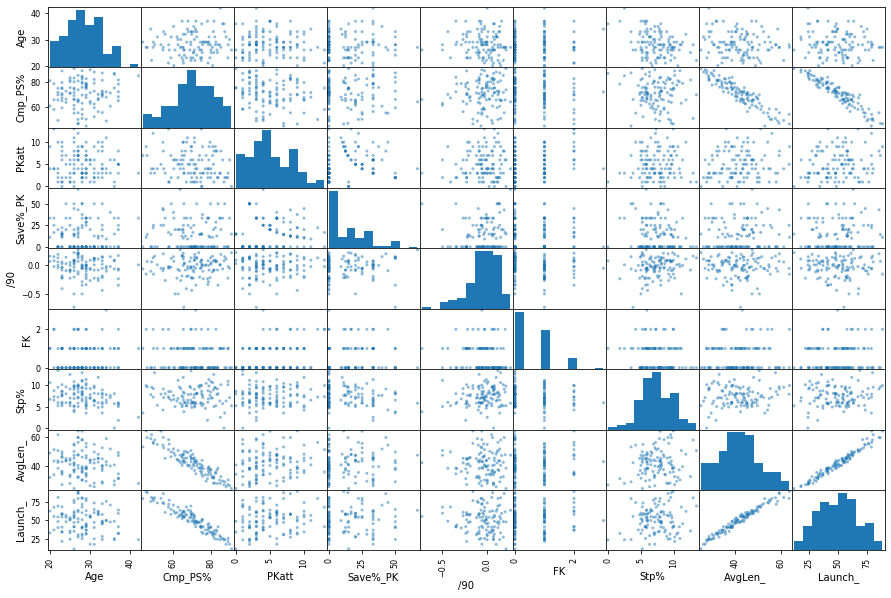

In [18]:
attributes = dt_gk.columns
scatter_matrix(dt_gk[attributes], figsize=(15, 10));

Valutiamo adesso nello specifico la correlazione di alcune coppie di attributi che dal grafico sembrano essere correlate

In [19]:
dt_gk["Cmp_PS%"].corr(dt_gk["AvgLen_"])

-0.9234706953636397

$ \textit{Cmp_PS%  } $ e $ \textit{AvgLen_ } $ sono fortemente correlate (negativamente); infatti, tendenzialmente, maggiore è la lunghezza di un passaggio/lancio, minore è la precisione.

Lasciamo $ \textit{Cmp_PS%  } $ perchè indica maggiormente la qualità con i piedi del portiere mentre  $ \textit{AvgLen_ } $ solo la "forza" del portiere nel calciare

In [20]:
dt_gk["Cmp_PS%"].corr(dt_gk["Launch_"])

-0.947426615624956

Anche in questo caso c'è correlazione; tra le due, eliminiamo $ \textit{Launch_ } $ in quanto meno significativo di $ \textit{Cmp_PS%  } $

In [21]:
dt_gk=dt_gk.drop([ "Launch_", "AvgLen_"], axis=1)

In [22]:
dt_gk.corr()

Age   Cmp_PS%     PKatt  Save%_PK       /90        FK      Stp%
Age       1.000000  0.092764 -0.065003 -0.004072 -0.076887  0.054639 -0.329604
Cmp_PS%   0.092764  1.000000 -0.187426 -0.015508  0.072230 -0.114445 -0.059278
PKatt    -0.065003 -0.187426  1.000000  0.110483  0.059963  0.303556  0.056104
Save%_PK -0.004072 -0.015508  0.110483  1.000000  0.106444  0.031108 -0.189678
/90      -0.076887  0.072230  0.059963  0.106444  1.000000 -0.165706  0.178561
FK        0.054639 -0.114445  0.303556  0.031108 -0.165706  1.000000 -0.162567
Stp%     -0.329604 -0.059278  0.056104 -0.189678  0.178561 -0.162567  1.000000

Non ci sono altri attributi correlati, procediamo con le altre operazioni di preprocessing

<font size=4>**Normalizzazione**</font>

In [23]:
pd.DataFrame(data=dt_gk.mean(), columns=["mean"])

mean
Age       28.324324
Cmp_PS%   70.526126
PKatt      5.045045
Save%_PK  14.823364
/90       -0.044865
FK         0.585586
Stp%       7.394595

Scaliamo i valori delle colonne rimaste in quanto hanno scale molto diverse tra di loro. 

Creiamo due nuovi dataFrame:
- **plotS** che useremo quando andremo a plottare i risultati con i valori scalati
- **plotNS** che contiene le informazioni non scalate che useremo per la valutazione effettiva dei cluster

In [24]:
plotNS = dt_gk

In [25]:
scaler = StandardScaler()

dt_gk = pd.DataFrame(scaler.fit_transform(dt_gk), index=dt_gk.index, columns= dt_gk.columns)

plotS = pd.DataFrame.copy(dt_gk)

Gli attributi rimasti indicano:

- l'età ($ \textit{Age}$);

- il numero di rigori concessi agli avversari ($ \textit{PKatt}$);

- la percentuale di passaggi e lanci completati ($ \textit{Cmp_PS%  } $), quindi l'abilità del portiere coi piedi;

- la percentuale di rigori parati ($ \textit{Save%_ PK)}$, quindi l'abilità del portiere nel parare i rigori;

- il numero di gol subiti da calcio di punizione ($ \textit{FK}$), quindi l'abilità nel posizionare la barriera e nel parare le punizioni avversarie;

- la percentuale di cross stoppati dal portiere ($ \textit{Stp%} $), quindi l'abilità nelle uscite sui cross;

- la differenza (normalizzata rispetto ai minuti giocati) tra la  probabilità che i tiri subiti si trasformino in gol e i gol effettivamente subiti ($ \textit{/90} $). La probabilità che i tiri subiti si trasformino in gol, quindi la pericolosità dei tiri ricevuti, è misurato tramite una metrica statistica complessa, i PostShot-Expected Goals, che assegna un punteggio ad ogni tiro sulla base della posizione del tiratore, della locazione del tiro nello specchio della porta, della traiettoria e velocità del tiro ed una serie di altre informazioni sul tiro. L'attributo presente nel DataFrame è, quindi, la differenza tra questo indice di pericolosità dei tiri ricevuti e i gol effettivamente subiti, quindi misura l'abilità del portiere nelle parate.

<font size=6> Clustering </font>

Applichiamo i primi algoritmi di clustering prima di fare il parameter tuning per valutarne il comportamento generale. Per fare questa simulazione scegliamo un numero di cluster $k=7$.

In [26]:
kmeans = KMeans(n_clusters=7, random_state=0)

plotS['cluster'] = kmeans.fit_predict(plotS[['/90', 'Cmp_PS%', 'Stp%', 'FK', 'Save%_PK', 'Age']])
kmeans.inertia_

341.3342048166535

Valutiamo le informazioni non scalate per analizzare ed interpretare i cluster (questo perchè ai fini della valutazione dei cluster le informazioni scalate non hanno molto significato).

In [27]:
plotNS["cluster"] = plotS["cluster"]
{i: plotNS.iloc[np.where(kmeans.labels_ == i)] for i in range(kmeans.n_clusters)}

{0:                     Age  Cmp_PS%  PKatt   Save%_PK   /90  FK  Stp%  cluster
 Claudio Bravo        37     65.0      5  20.000000  0.16   0   5.4        0
 David Soria          27     46.8      7  14.300000  0.06   0   9.6        0
 Fraser Forster       32     56.2      3  33.300000 -0.27   0   8.0        0
 Jasper Cillessen     31     59.3      2  50.000000  0.11   1   6.5        0
 Jean-Louis Leca      34     67.8     11   9.100000 -0.03   0   6.5        0
 Marko DmitroviÄ‡     28     54.0      5  25.000000 -0.06   0   7.9        0
 Paulo Gazzaniga      28     58.0      1   0.000000 -0.06   0   8.5        0
 Roberto              34     48.7      3   0.000000 -0.11   0   7.8        0
 Romain Salin         36     75.2      0  14.823364  0.08   0   8.0        0
 Sergio Herrera       27     55.2      8  42.900000  0.19   0   9.1        0
 Vicente Guaita       33     55.4      4  25.000000 -0.06   1   7.1        0
 Åukasz FabiaÅ„ski   35     60.5      6  40.000000  0.14   0   7.6      

Si può notare che il cluster 2 è molto variegato (contiene portieri con ottime statistiche come Sergio Rico ed Ederson, ma anche portieri con basse statistiche come RubÃ©n YÃ¡Ã±ez o Ãlvaro FernÃ¡ndez); i record sono uniti in un unico cluster grazie all'attributo $ \textit{FK}$, che vale 0 per quasi tutti gli elementi e sembra avere un forte impatto sulla clusterizzazione.
Tuttavia, questo attributo, rappresentante il numero di gol subiti su punizione, è molto dipendente dal numero di punizioni concesse agli avversari e dalla posizione in cui vengono concesse queste punizioni (quindi dal gioco della squadra più che del portiere). Inoltre, i calci di punizione sono compresi nel calcolo di $ \textit{/90} $, quindi crediamo sia meglio eliminare $ \textit{FK}$.

In [28]:
dt_gk=dt_gk.drop("FK", axis=1)
plotS=plotS.drop("FK", axis=1)
plotNS=plotNS.drop("FK", axis=1)

dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 6 columns):
Age         111 non-null float64
Cmp_PS%     111 non-null float64
PKatt       111 non-null float64
Save%_PK    111 non-null float64
/90         111 non-null float64
Stp%        111 non-null float64
dtypes: float64(6)
memory usage: 6.1+ KB


<font size=5 >Consideriamo 5 attributi</font>

In [29]:
kmeans = KMeans(n_clusters=7, random_state=0)

plotS['cluster'] = kmeans.fit_predict(plotS[['/90', 'Cmp_PS%', 'Stp%', "Age", 'Save%_PK']])
kmeans.inertia_

249.12967179089833

Stampiamo adesso i cluster con i dati non scalati, in modo da interpretarli più facilmente.

In [30]:
plotNS["cluster"] = plotS["cluster"]
#stampiamo i vari cluster
{i: plotNS.iloc[np.where(kmeans.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age','Save%_PK'] ] for i in range(kmeans.n_clusters)}

{0:                          /90  Cmp_PS%  Stp%  Age   Save%_PK
 Alban Lafont           -0.03     57.9   7.3   21  16.700000
 Anthony Racioppi        0.14     65.7   6.5   21  25.000000
 BartÅ‚omiej DrÄ…gowski -0.01     65.5   7.2   22  20.000000
 CÃ¡rdenas               0.05     74.6   5.7   23  14.823364
 Dean Henderson          0.02     75.2   8.6   23  14.823364
 Emil Audero            -0.05     69.6   7.9   23  22.200000
 Etienne Green           0.06     60.7   6.7   20  33.300000
 Gautier Larsonneur     -0.22     79.5   7.6   23  11.100000
 Gianluigi Donnarumma    0.07     78.5   8.7   21  33.300000
 Mattia Perin            0.15     65.0   5.0   27   0.000000
 Paul Bernardoni        -0.19     64.9   7.5   23  12.500000
 Pierluigi Gollini      -0.01     75.4   5.2   25  33.300000
 Predrag RajkoviÄ‡       0.02     66.2   5.9   24  33.300000
 Robert SÃ¡nchez         0.18     71.6   5.2   22   0.000000
 Sergio Rico             0.21     90.7   5.2   26  14.823364
 Unai SimÃ³n         

Una discreta percentuale dei portieri analizzati ha subito pochi rigori, un numero sicuramente insufficiente per valutare l'abilità nel parare i rigori tramite $ \textit{Save%_PK}$. Di conseguenza, le percentuali, specialmente quelle alte, sono poco significative (ad esempio, un portiere che ha parato un rigore sui 2 ricevuti avrà una percentuale del 50%, difficile da raggiungere su un numero più elevato di rigori). Come è possibile vedere dal grafico sotto infatti, la quasi totalità dei portieri con almeno 4 rigori subiti(sopra la linea verde) è posizionata a sinistra delle linea rossa corrispondente al 35%.

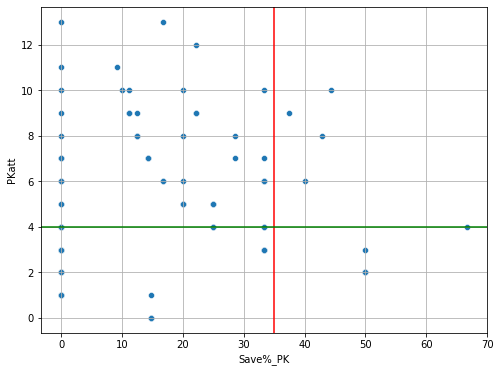

In [31]:
plt.figure(figsize=(8,6))
p = sns.scatterplot(x = 'Save%_PK', y = 'PKatt', data = plotNS[["Save%_PK","PKatt"]])
plt.axvline(35, color='r')
plt.grid()
plt.axhline(4, color='g')

In [32]:
dt_gk=dt_gk.drop(["Save%_PK", "PKatt"], axis=1)
plotS=plotS.drop(["Save%_PK", "PKatt"], axis=1)
plotNS=plotNS.drop(["Save%_PK", "PKatt"], axis=1)
dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 4 columns):
Age        111 non-null float64
Cmp_PS%    111 non-null float64
/90        111 non-null float64
Stp%       111 non-null float64
dtypes: float64(4)
memory usage: 9.3+ KB


<font size=5>Consideriamo 4 attributi </font>

In [33]:
kmeans = KMeans(n_clusters=7, random_state=0)

plotS['cluster'] = kmeans.fit_predict(plotS[['/90', 'Cmp_PS%', 'Stp%', 'Age']])
kmeans.inertia_

166.45944450239188

In [34]:
silhouette_score(dt_gk, kmeans.labels_)

0.20782997682085377

Proviamo a valutare le informazioni dei cluster con le informazioni non scalate. 

In [35]:
plotNS["cluster"] = plotS["cluster"]
#stampiamo i vari cluster
{i: plotNS.iloc[np.where(kmeans.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ] for i in range(kmeans.n_clusters)}

{0:                      /90  Cmp_PS%  Stp%  Age
 Aaron Ramsdale      0.05     49.1   9.5   22
 David Soria         0.06     46.8   9.6   27
 Emiliano MartÃ­nez  0.20     65.6   8.4   27
 IvÃ¡n Villar       -0.04     59.2   8.5   23
 JeremÃ­as Ledesma  -0.16     46.3   9.9   27
 Karl Darlow        -0.16     50.1   9.2   29
 Lorenzo MontipÃ²   -0.10     63.6   9.6   24
 Marko DmitroviÄ‡   -0.06     54.0   7.9   28
 Nick Pope           0.15     50.7  12.9   28
 Paulo Gazzaniga    -0.06     58.0   8.5   28
 RubÃ©n YÃ¡Ã±ez     -0.04     58.3   6.9   26
 Sam Johnstone       0.12     49.9   7.2   27
 Sergio Herrera      0.19     55.2   9.1   27,
 1:                           /90  Cmp_PS%  Stp%  Age
 Angelo da Costa JÃºnior  0.07     86.8   0.0   36
 Antonio Mirante         -0.24     78.2   1.8   37
 Gianluigi Buffon         0.00     84.9   2.5   42
 Keylor Navas             0.14     87.2   3.5   33
 Pepe Reina              -0.09     81.6   5.0   37
 Samir HandanoviÄ‡       -0.07     86.1   5

In [36]:
dt_gk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 4 columns):
Age        111 non-null float64
Cmp_PS%    111 non-null float64
/90        111 non-null float64
Stp%       111 non-null float64
dtypes: float64(4)
memory usage: 9.3+ KB


Gli attributi rimasti sono quelli che meglio rappresentano un portiere ai fini della nostra analisi.

<h2>Tuning dei parametri</h2>

Abbiamo determinato quanti e quali attributi lasciare per l'analisi definitiva. Adesso effettuamo il tuning del parametro $k$ cercando di combinare 3 approcci: l'elbow method, il silhouette method e il clustering gerarchico.

<h3> <strong> Elbow method </strong> </h3>

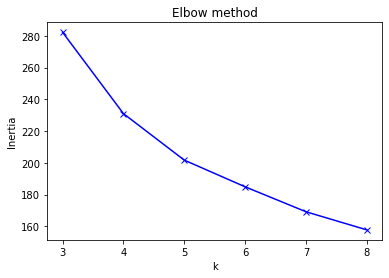

In [37]:
inertia = []
K = range(3,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dt_gk)
    inertia.append(kmeanModel.inertia_)


# Plot the elbow

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("Elbow method", loc="center")

plt.show()

<h3> <strong> Hierarchical clustering </strong> </h3>

In [38]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

dt_gk

Age   Cmp_PS%       /90      Stp%
Aaron Ramsdale     -1.426317 -1.988458  0.557016  0.920101
Aitor FernÃ¡ndez    0.152384  0.489444 -0.382453 -0.128743
Alban Lafont       -1.651845 -1.171772  0.087282 -0.041340
Alessio Cragno     -0.524202 -0.141633  0.615733  1.007505
Alex Cordaz         1.956614  0.146064 -1.791656 -0.740569
...                      ...       ...       ...       ...
Ãlex Remiro       -0.749731  0.053259 -0.441169 -0.696867
Ãlvaro FernÃ¡ndez -1.426317  0.405919 -0.030152 -0.653166
Ã‰dgar BadÃ­a      -0.073144  0.470882  0.204715  0.089766
Åukasz FabiaÅ„ski  1.505557 -0.930478  1.085467  0.089766
Åukasz Skorupski   0.152384  0.647213  0.263432  1.313418

[111 rows x 4 columns]

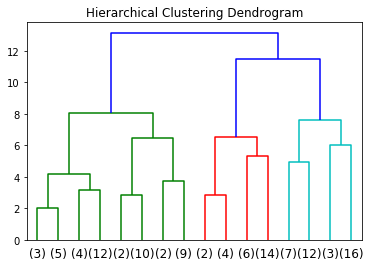

In [84]:
model = AgglomerativeClustering(distance_threshold=60, n_clusters=None, compute_distances=True)
model = model.fit(dt_gk)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

<h3><strong> Silhouette method </strong></h3>

In [40]:
range_ = range(3, 9)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dt_gk)
                for k in range_]

In [41]:
silhouette_scores = [silhouette_score(dt_gk, model.labels_)
                     for model in kmeans_per_k]
silhouette_scores

[0.2066769595570496,
 0.22992120674490313,
 0.22053648041115537,
 0.19987561204253848,
 0.2075473917599974,
 0.223339213102719]

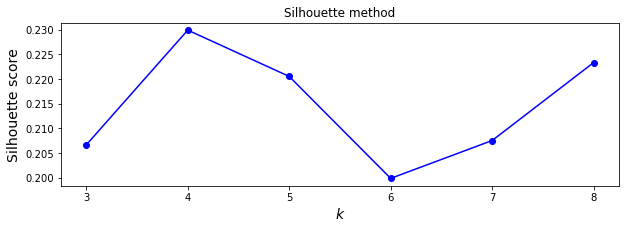

In [42]:
plt.figure(figsize=(10, 3))
plt.plot(range_, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette method", loc="center")
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.21256623808453717
For n_clusters = 4 The average silhouette_score is : 0.22726885828106883
For n_clusters = 5 The average silhouette_score is : 0.22173942939921626
For n_clusters = 6 The average silhouette_score is : 0.21815371443920376
For n_clusters = 7 The average silhouette_score is : 0.2083261433102467
For n_clusters = 8 The average silhouette_score is : 0.21175035151354318


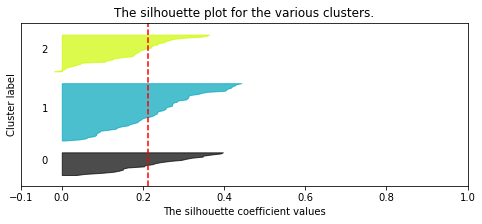

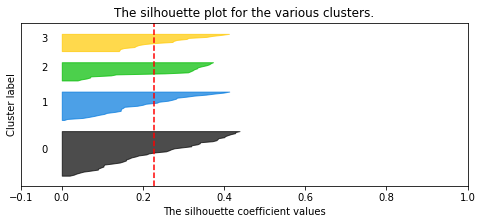

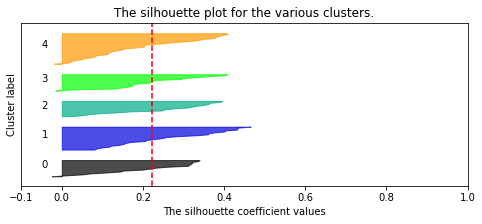

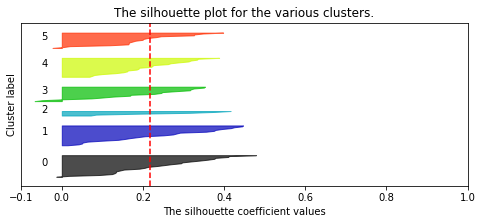

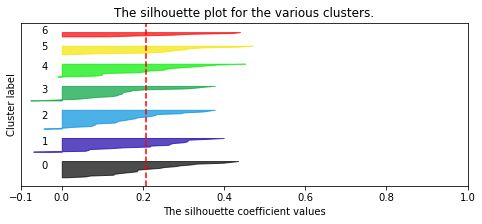

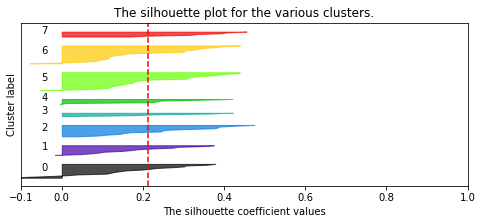

In [43]:
range_n_clusters = range_
X = dt_gk

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(8,3)


    
    ax1.set_xlim([-0.1, 1])
    
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show();

**Considerazioni sul numero di cluster**

- Esaminando l'Elbow method si nota una chiara curvatura del grafico in prossimità di 5

- Dal clustering  gerarchico notiamo che subito dopo la formazione del quinto cluster è presente un intervallo abbastanza ampio prima della merge successiva.

- Sebbene il valore del silhouette score non sia il più alto in assoluto in corrispondenza di $5$, nei silhouette plots notiamo che i cluster superano tutti il valore medio evidenziato in rosso ed inoltre hanno tutti una dimensione comparabile

A seguito di queste considerazioni abbiamo scelto come numero di cluster il valore: $$k=5$$

<h1> Selezione del modello </h1>

Proviamo l'$\textit{agglomerative clustering}$ e il $\textit{kmeans}$ con $k=5$

<h3>Agglomerative clustering</h3>

In [44]:
agg_clustering = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')

plotAggl = pd.DataFrame.copy(plotS[['/90', 'Cmp_PS%', 'Stp%', 'Age']])
plotAggl["cluster"] = agg_clustering.fit_predict(plotS[['/90', 'Cmp_PS%', 'Stp%', 'Age']])

silhouette=silhouette_score(dt_gk,agg_clustering.labels_)
print("Silhouette score={}".format( silhouette))

Silhouette score=0.1666623975922542


In [45]:
{i: plotNS.iloc[np.where(agg_clustering.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ] for i in range(agg_clustering.n_clusters)}

{0:                           /90  Cmp_PS%  Stp%  Age
 Andrea Consigli          0.07     81.3   8.9   33
 Angelo da Costa JÃºnior  0.07     86.8   0.0   36
 Anthony Lopes            0.05     82.6   5.2   29
 Antonio Mirante         -0.24     78.2   1.8   37
 Claudio Bravo            0.16     65.0   5.4   37
 David Ospina             0.07     82.0   9.4   31
 David de Gea            -0.01     77.1   4.6   29
 Edouard Mendy            0.00     84.6   6.3   28
 Eiji Kawashima          -0.07     68.1   5.9   37
 Gianluigi Buffon         0.00     84.9   2.5   42
 Hugo Lloris              0.13     71.5   4.9   33
 Jasper Cillessen         0.11     59.3   6.5   31
 Jean-Louis Leca         -0.03     67.8   6.5   34
 Jessy Moulin            -0.06     72.0   5.9   34
 Kasper Schmeichel        0.01     72.7   8.1   33
 Keylor Navas             0.14     87.2   3.5   33
 Martin DÃºbravka         0.11     72.6   8.1   31
 Neto                     0.10     87.9   6.3   31
 Pepe Reina              -0.

<h3>K-means</h3>


In [46]:
kmeans_DEF = KMeans(n_clusters=5, random_state=0)

plotS['cluster'] = kmeans_DEF.fit_predict(plotS[['/90', 'Cmp_PS%', 'Stp%', 'Age']])
kmeans_DEF.inertia_

201.40643444383306

In [47]:
silhouette_score(dt_gk, kmeans_DEF.labels_)

0.22173942939921626

In [48]:
{i: plotNS.iloc[np.where(kmeans_DEF.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ] for i in range(kmeans_DEF.n_clusters)}

{0:                          /90  Cmp_PS%  Stp%  Age
 Alban Lafont           -0.03     57.9   7.3   21
 Anthony Racioppi        0.14     65.7   6.5   21
 BartÅ‚omiej DrÄ…gowski -0.01     65.5   7.2   22
 CÃ¡rdenas               0.05     74.6   5.7   23
 Dean Henderson          0.02     75.2   8.6   23
 Emil Audero            -0.05     69.6   7.9   23
 Emiliano MartÃ­nez      0.20     65.6   8.4   27
 Etienne Green           0.06     60.7   6.7   20
 Gautier Larsonneur     -0.22     79.5   7.6   23
 Gianluigi Donnarumma    0.07     78.5   8.7   21
 IvÃ¡n Villar           -0.04     59.2   8.5   23
 Jan Oblak               0.26     64.0   5.8   27
 Jaume DomÃ©nech        -0.03     69.5   6.5   29
 Jordan Pickford         0.03     66.1   8.1   26
 Lorenzo MontipÃ²       -0.10     63.6   9.6   24
 Mattia Perin            0.15     65.0   5.0   27
 Mike Maignan            0.13     72.6   8.0   24
 Pau LÃ³pez              0.04     80.1   7.0   25
 Paul Bernardoni        -0.19     64.9   7.5   

Da una prima osservazione dei cluster generati si nota come anche l'agglomerative clustering fornisca buoni risultati, riuscendo a distinguere abbastanza bene le varie tipologie di portieri.
A questa tecnica preferiamo comunque il kmeans che offre un valore migliore del silhouette score.



<h1> Plotting, analisi e interpretazione dei risultati</h1>


Plottiamo i cluster a più dimensioni usando la tecnica della  $\textit{Principal Component Analysis (PCA)}$

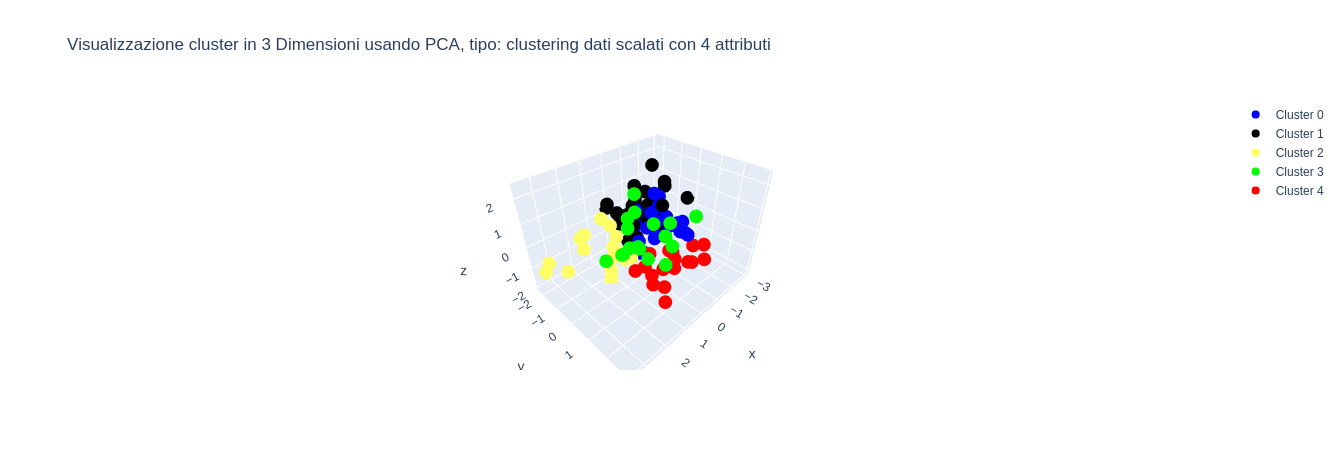

In [49]:
plot_PCA(plotS[['/90', 'Cmp_PS%', 'Stp%', 'Age', 'cluster']],5,3, "clustering dati scalati con 4 attributi")

In [50]:
plotNS["cluster"] = plotS["cluster"]
#{i: plotNS.iloc[np.where(kmeans_DEF.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ] for i in range(kmeans_DEF.n_clusters)}
{i: plotNS.iloc[np.where(kmeans_DEF.labels_ == i)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ][0:10] for i in range(kmeans_DEF.n_clusters)}

{0:                          /90  Cmp_PS%  Stp%  Age
 Alban Lafont           -0.03     57.9   7.3   21
 Anthony Racioppi        0.14     65.7   6.5   21
 BartÅ‚omiej DrÄ…gowski -0.01     65.5   7.2   22
 CÃ¡rdenas               0.05     74.6   5.7   23
 Dean Henderson          0.02     75.2   8.6   23
 Emil Audero            -0.05     69.6   7.9   23
 Emiliano MartÃ­nez      0.20     65.6   8.4   27
 Etienne Green           0.06     60.7   6.7   20
 Gautier Larsonneur     -0.22     79.5   7.6   23
 Gianluigi Donnarumma    0.07     78.5   8.7   21,
 1:                     /90  Cmp_PS%  Stp%  Age
 Aitor FernÃ¡ndez  -0.11     75.8   7.1   29
 Alessio Cragno     0.06     69.0   9.7   26
 Alex Meret        -0.23     88.8  10.1   23
 Alexandre Oukidja  0.10     65.6  11.8   32
 Alfred Gomis       0.01     80.0  10.8   26
 Alisson            0.18     85.2  10.1   27
 Alphonse Areola    0.21     73.6   9.8   27
 Andrea Consigli    0.07     81.3   8.9   33
 Bernd Leno         0.12     79.8   8.

In [51]:
plotNS.mean()

Age        28.324324
Cmp_PS%    70.526126
/90        -0.044865
Stp%        7.394595
cluster     1.738739
dtype: float64

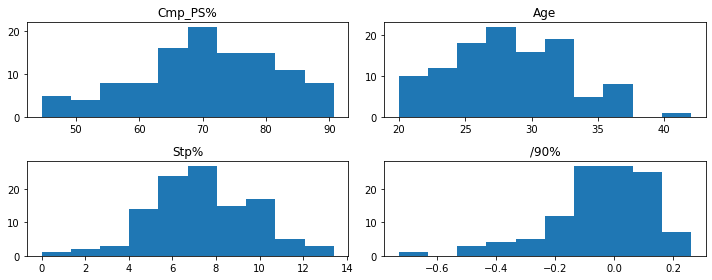

In [52]:
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(plotNS["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(plotNS["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(plotNS["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(plotNS["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

<h3>Interpretazione dei cluster basata sulla distribuzione delle statistiche ed utilizzando i DecisionTree</h3>

Stampo il valore medio, la cardinalità e gli istogrammi di ogni attributo, cluster per cluster. Insieme alle stampe fatte sopra, serviranno per analizzare ed interpretare i cluster "manualmente". Inoltre, automatizziamo l'interpretazione dei cluster applicando il DecisionTreeClassifier, estraendo le regole che portano ad assegnare un record ai vari cluster (classi).

In [53]:
#splitto il dataset spezzando in attributo di classe e la restante parte
train_set = pd.DataFrame.copy(plotNS[['/90', 'Cmp_PS%', 'Stp%', 'Age',"cluster"]])

Y = train_set["cluster"].values
train_set.drop("cluster", axis=1, inplace=True)

clf = tree.DecisionTreeClassifier(random_state = 1)
clf = clf.fit(train_set, Y)

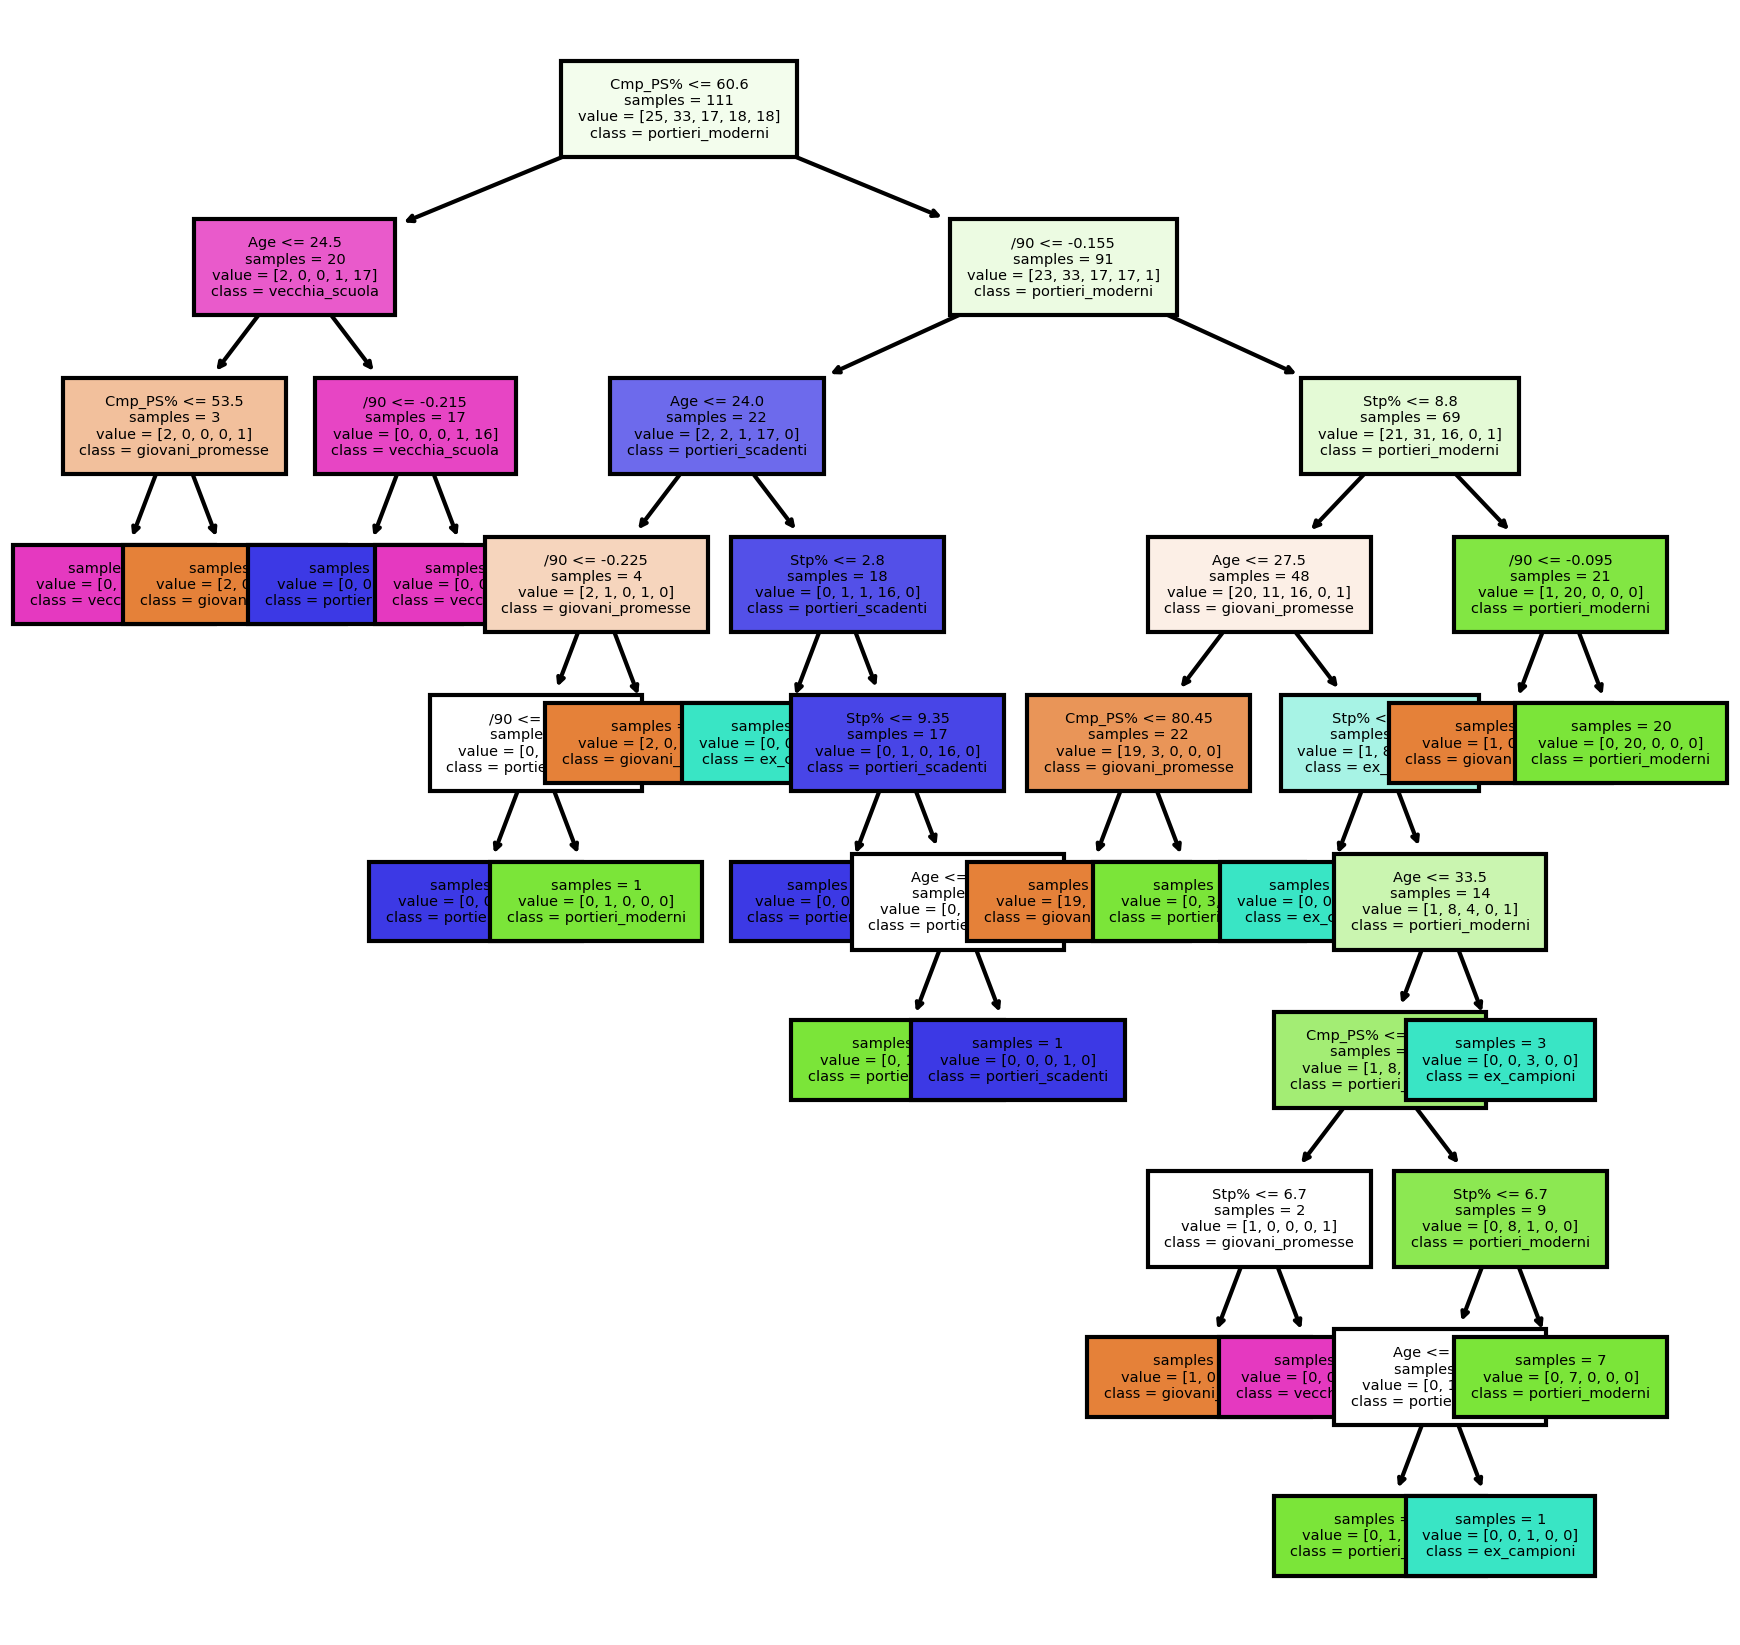

In [54]:
fn=['/90', 'Cmp_PS%', 'Stp%', 'Age']
cn = ['giovani_promesse', 'portieri_moderni',  'ex_campioni', 'portieri_scadenti', 'vecchia_scuola'  ]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7,7), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names = cn,
               filled = True, impurity=False, fontsize=3.5);

In [55]:
text_representation = tree.export_text(clf, feature_names=fn)
for i in range(5):
    text_representation = text_representation.replace("class: {}".format(i), cn[i])
rules=estrai_regole(text_representation)
rules

['Cmp_PS% <= 60.60 - Age <= 24.50 - Cmp_PS% <= 53.50 - classe=vecchia_scuola',
 'Cmp_PS% <= 60.60 - Age <= 24.50 - Cmp_PS% >  53.50 - classe=giovani_promesse',
 'Cmp_PS% <= 60.60 - Age >  24.50 - /90 <= 0.22 - classe=portieri_scadenti',
 'Cmp_PS% <= 60.60 - Age >  24.50 - /90 >  0.22 - classe=vecchia_scuola',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 <= 0.23 - /90 <= 0.32 - classe=portieri_scadenti',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 <= 0.23 - /90 >  0.32 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 >  0.23 - classe=giovani_promesse',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% <= 2.80 - classe=ex_campioni',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% <= 9.35 - classe=portieri_scadenti',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% >  9.35 - Age <= 27.00 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% >  9.3

<font size=5> Cluster 0  - Giovani promesse</font>

/90         0.0164
Cmp_PS%    69.1040
Stp%        6.9840
Age        23.7200
dtype: float64
Cardinalità del cluster 25


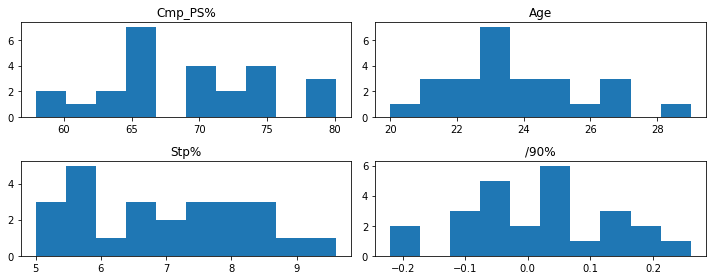

In [56]:
cluster=pd.DataFrame(plotNS.iloc[np.where(kmeans_DEF.labels_ == 0)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ])
print(cluster.mean())
print("Cardinalità del cluster {}".format(len(cluster.index)))
#plottiamo gli istogrammi
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(cluster["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(cluster["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(cluster["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(cluster["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

In [57]:
ret=ottieni_regole_per_classe("giovani_promesse",rules)
ret

['Cmp_PS% <= 60.60 - Age <= 24.50 - Cmp_PS% >  53.50 - classe=giovani_promesse',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 >  0.23 - classe=giovani_promesse',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age <= 27.50 - Cmp_PS% <= 80.45 - classe=giovani_promesse',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age <= 33.50 - Cmp_PS% <= 70.45 - Stp% <= 6.70 - classe=giovani_promesse',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% >  8.80 - /90 <= 0.10 - classe=giovani_promesse']

Contiene portieri giovani (età media 23.72, solo uno supera i 27 anni), caratterizzati da una buona abilità tra i pali (il valore medio di $ \textit{/90}$ è positivo, tendenzialmente hanno tutti ottimi valori per questo attributo ma è presente qualche eccezione come Gautier Larsonneur o Paul Bernardoni) e coi piedi (in realtà, vi sono diversi giocatori con un valore non alto di $ \textit{Cmp_PS%}$, però la media sul cluster supera il valore medio su tutto il dataset).

Nel seguito chiameremo i portieri di questo cluster **"giovani promesse"**.

<font size=5> Cluster 1 - Portieri moderni</font>

/90         0.019394
Cmp_PS%    78.454545
Stp%        9.281818
Age        27.666667
dtype: float64
Cardinalità del cluster 33


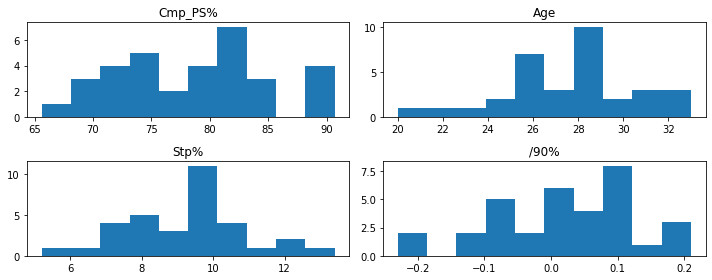

In [58]:
cluster=pd.DataFrame(plotNS.iloc[np.where(kmeans_DEF.labels_ == 1)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ])
print(cluster.mean())
print("Cardinalità del cluster {}".format(len(cluster.index)))
#plottiamo gli istogrammi
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(cluster["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(cluster["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(cluster["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(cluster["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

In [59]:
ret=ottieni_regole_per_classe("portieri_moderni",rules)
ret

['Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 <= 0.23 - /90 >  0.32 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% >  9.35 - Age <= 27.00 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age <= 27.50 - Cmp_PS% >  80.45 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age <= 33.50 - Cmp_PS% >  70.45 - Stp% <= 6.70 - Age <= 29.50 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age <= 33.50 - Cmp_PS% >  70.45 - Stp% >  6.70 - classe=portieri_moderni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% >  8.80 - /90 >  0.10 - classe=portieri_moderni']

Contiene portieri molto abili coi piedi (tranne qualche eccezione, tutti hanno  $ \textit{Cmp_PS%} $ maggiore della media) e nelle uscite sui cross (quasi 2 punti percentuali in più in media). Si nota anche una maggiore presenza di portieri con un valore positivo di $ \textit{/90} $, segno che la maggior parte dei portieri del cluster si segnalano per una buona abilità tra i pali.

I portieri di questo cluster sono, quindi, caratterizzati dall'avere buone doti nelle caratteristiche che vengono maggiormente richieste oggi ai portieri; li definiremo i **"portieri moderni"**.

<font size=5> Cluster 2 - ex campioni</font>

/90         0.002353
Cmp_PS%    77.047059
Stp%        4.952941
Age        34.588235
dtype: float64
Cardinalità del cluster 17


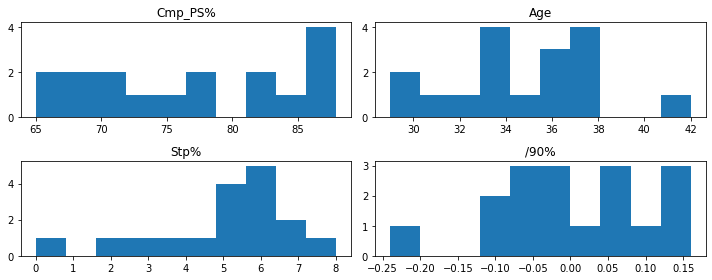

In [60]:
cluster=pd.DataFrame(plotNS.iloc[np.where(kmeans_DEF.labels_ == 2)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ])
print(cluster.mean())
print("Cardinalità del cluster {}".format(len(cluster.index)))
#plottiamo gli istogrammi
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(cluster["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(cluster["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(cluster["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(cluster["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

In [61]:
ret=ottieni_regole_per_classe("ex_campioni",rules)
ret

['Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% <= 2.80 - classe=ex_campioni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% <= 6.10 - classe=ex_campioni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age <= 33.50 - Cmp_PS% >  70.45 - Stp% <= 6.70 - Age >  29.50 - classe=ex_campioni',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age >  33.50 - classe=ex_campioni']

Contiene portieri di età avanzata (34.59 anni in media), caratterizzati da una bassa ($ \textit{Stp%} $ ben al di sotto della media) abilità nell'intervenire sui cross in area di rigore ed una buona capacità coi piedi. Sono quasi tutti portieri con un'ottima carriera alle spalle, gli **"ex campioni"**.

<font size=5> Cluster 3 - portieri scadenti</font>

/90        -0.332778
Cmp_PS%    69.177778
Stp%        6.450000
Age        29.555556
dtype: float64
Cardinalità del cluster 18


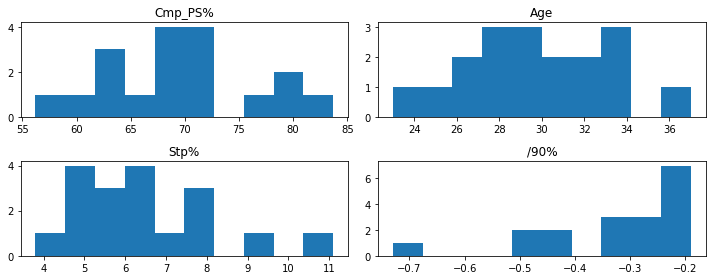

In [62]:
cluster=pd.DataFrame(plotNS.iloc[np.where(kmeans_DEF.labels_ == 3)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ])
print(cluster.mean())
print("Cardinalità del cluster {}".format(len(cluster.index)))
#plottiamo gli istogrammi
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(cluster["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(cluster["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(cluster["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(cluster["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

In [63]:
ret=ottieni_regole_per_classe('portieri_scadenti',rules)
ret

['Cmp_PS% <= 60.60 - Age >  24.50 - /90 <= 0.22 - classe=portieri_scadenti',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age <= 24.00 - /90 <= 0.23 - /90 <= 0.32 - classe=portieri_scadenti',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% <= 9.35 - classe=portieri_scadenti',
 'Cmp_PS% >  60.60 - /90 <= 0.15 - Age >  24.00 - Stp% >  2.80 - Stp% >  9.35 - Age >  27.00 - classe=portieri_scadenti']

Contiene i portieri con una scarsa abilità nelle parate (valori dell'attributo $ \textit{/90} $ tutti abbondantemente sotto lo 0, segno che in questa stagione hanno subito più gol di quanti avrebbero dovuto subirne sulla base della pericolosità dei tiri ricevuti). Chiameremo questi portieti i **"portieri scadenti"**.

<font size=5> Cluster 4 - vecchia scuola </font>

/90        -0.004444
Cmp_PS%    53.155556
Stp%        7.755556
Age        28.777778
dtype: float64
Cardinalità del cluster 18


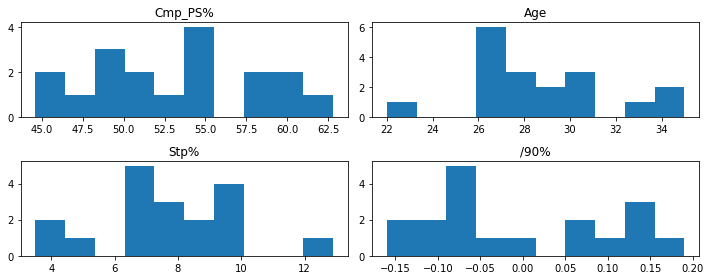

In [64]:
cluster=pd.DataFrame(plotNS.iloc[np.where(kmeans_DEF.labels_ == 4)][['/90', 'Cmp_PS%', 'Stp%', 'Age'] ])
print(cluster.mean())
print("Cardinalità del cluster {}".format(len(cluster.index)))
#plottiamo gli istogrammi
fig, axs =plt.subplots(2,2,tight_layout=True)
axs[0][0].hist(cluster["Cmp_PS%"])
axs[0][0].set_title("Cmp_PS%")
axs[1][0].hist(cluster["Stp%"])
axs[1][0].set_title("Stp%")
axs[0][1].hist(cluster["Age"])
axs[0][1].set_title("Age")
axs[1][1].hist(cluster["/90"])
axs[1][1].set_title("/90%")
fig.set_size_inches(10, 4)

In [65]:
ret=ottieni_regole_per_classe('vecchia_scuola',rules)
ret

['Cmp_PS% <= 60.60 - Age <= 24.50 - Cmp_PS% <= 53.50 - classe=vecchia_scuola',
 'Cmp_PS% <= 60.60 - Age >  24.50 - /90 >  0.22 - classe=vecchia_scuola',
 'Cmp_PS% >  60.60 - /90 >  0.15 - Stp% <= 8.80 - Age >  27.50 - Stp% >  6.10 - Age <= 33.50 - Cmp_PS% <= 70.45 - Stp% >  6.70 - classe=vecchia_scuola']

Questa tipologia di portiere identifica i portieri **"vecchia scuola"**, ossia che non spiccano per l'abilità coi piedi (media di cluster di $ \textit{Cmp_PS%} $ ben al di sotto della media su tutto il dataset), caratteristica che solo in tempi moderni è stata richiesta ai portieri.

I portieri di quest'ultimo cluster giocano, probabilmente, in squadre (è sicuramente il caso di Marco Silvestri dell'Hellas Verona, per esempio) che non sfruttano molto il gioco palla a terra a partire dalla difesa e dal portiere, tendendo ad affidarsi maggiormente al lancio lungo. Da un lato, ciò contribuisce a peggiorare la percentuale $ \textit{Cmp_PS%} $ di passaggi riusciti del proprio portiere (è molto più probabile sbagliare un passaggio lungo e alto piuttosto che un passaggio corto e rasoterra); dall'altro, date le percentuali notevolmente basse, il gioco col pallone è un aspetto che non è nelle corde di questi portieri, quindi comprensibilmente la squadra non ci fa molto affidamento.


<h2>Esempio pratico</h2>

Alla luce di quest'analisi, se dovessimo consigliare un nuovo portiere ad una squadra come il Sassuolo che lo sfrutta per costruire l'azione e che deve rinunciare al proprio (per esempio per la cessione o la scadenza del contratto), non consiglieremmo un portiere dell'ultimo cluster bensì dei primi due. In particolare, se l'età ($ \textit{Age}$) fosse un fattore rilevante per la squadra in questione, ci si potrebbe concentrare sul cluster 0 (giovani promesse), mentre se l'abilità nelle uscite sui cross ($ \textit{Stp%} $) fosse un fattore più importante per la squadra, il cluster 1 (portieri moderni) potrebbe contenere giocatori più adatti. Se, invece, si volesse un portiere più abile tra i pali si potrebbe cercare un portiere del cluster 1 con un buon valore di $ \textit{/90}$ o 4 (vecchia scuola), magari rinunciando all'abilità coi piedi.

Consideriamo, dunque, tre portieri come possibili sostituti di Consigli al Sassuolo:
- Jasper Cillessen, appartenente al cluster 4;
- Emiliano Martinez, appartenente al cluster 0;
- Illan Meslier, appartenente al cluster 1 (lo stesso di Consigli).

Stampiamo i valori dei 4 portieri e, per un confronto più dettagliato, plottiamo i corrispondenti radar charts.

In [66]:
plotNS.loc[["Jasper Cillessen", "Andrea Consigli","Illan Meslier", "Emiliano MartÃ­nez"]][["Age","Cmp_PS%","/90","Stp%", "cluster"]]

Age  Cmp_PS%   /90  Stp%  cluster
Jasper Cillessen     31     59.3  0.11   6.5        4
Andrea Consigli      33     81.3  0.07   8.9        1
Illan Meslier        20     80.9  0.15  10.6        1
Emiliano MartÃ­nez   27     65.6  0.20   8.4        0

In [67]:
scaler = StandardScaler()
plot_radar = pd.DataFrame.copy(plotNS.loc[["Jasper Cillessen", "Andrea Consigli","Illan Meslier", "Emiliano MartÃ­nez"]][["Age","Cmp_PS%","/90","Stp%"]])
plot_radar = pd.DataFrame(scaler.fit_transform(plot_radar), index=plot_radar.index, columns=plot_radar.columns)
plot_radar

Age   Cmp_PS%       /90      Stp%
Jasper Cillessen    0.654101 -1.301055 -0.467257 -1.437210
Andrea Consigli     1.056625  0.993391 -1.297935  0.205316
Illan Meslier      -1.559779  0.951674  0.363422  1.368772
Emiliano MartÃ­nez -0.150946 -0.644009  1.401770 -0.136877

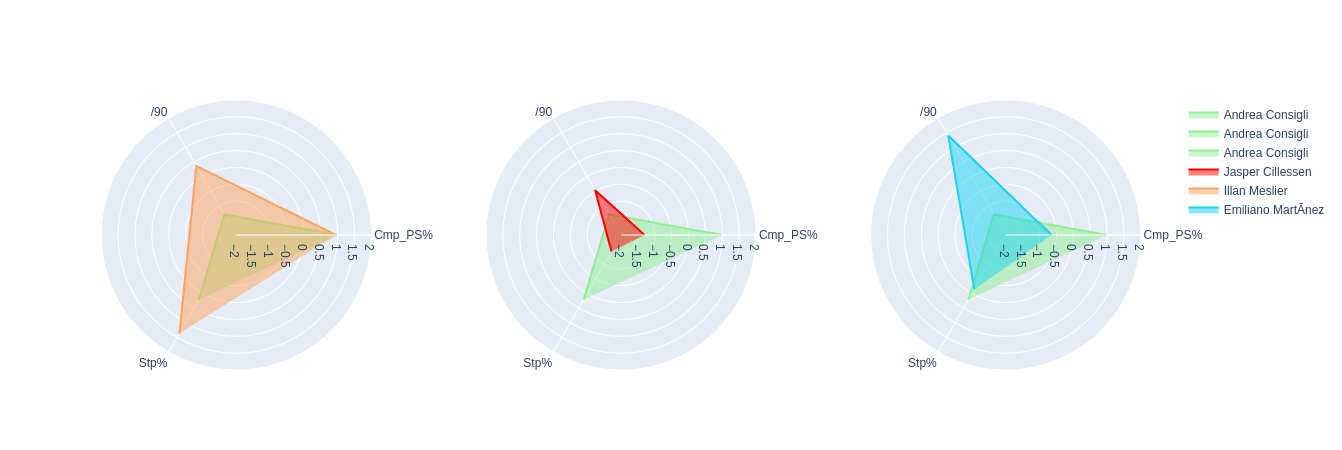

In [68]:
categories = ["Cmp_PS%","/90","Stp%"]
range_ = [-2, 2]

fig = go.Figure()


fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}]*3]*1)

fig.add_trace(go.Scatterpolar(
      r=plot_radar[["Cmp_PS%","/90","Stp%"]].loc["Andrea Consigli"],
      theta=categories,
      fill='toself',
      name='Andrea Consigli', 
    line_color = 'lightgreen', 
    mode='lines'


), row=[1, 1, 1], col=[1, 2, 3])


fig.add_trace(go.Scatterpolar(
      r=plot_radar[["Cmp_PS%","/90","Stp%"]].loc["Jasper Cillessen"],
      theta=categories,
      fill='toself',
      name='Jasper Cillessen',
      line_color = 'red', 
      mode='lines'
      ), row=1, col=2)



fig.add_trace(go.Scatterpolar(
      r=plot_radar[["Cmp_PS%","/90","Stp%"]].loc["Illan Meslier"],
      theta=categories,
      fill='toself',
      name='Illan Meslier', 
          mode='lines'

), row=1, col=1)

fig.add_trace(go.Scatterpolar(
      r=plot_radar[["Cmp_PS%","/90","Stp%"]].loc["Emiliano MartÃ­nez"],
      theta=categories,
      fill='toself',
      name='Emiliano MartÃ­nez', 
          mode='lines'

), row=1, col=3)

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=range_
    )),
   polar2=dict(
    radialaxis=dict(
      visible=True,
      range=range_
    )),
    polar3=dict(
        radialaxis=dict(
        visible=True,
        range=range_
    ))
)

fig.show(width=250, height=250)


<h4> $\textbf{Caso 1} $: consiglio di un nuovo portiere per il Sassuolo, nell'ipotesi in cui la squadra voglia mantenere lo stesso stile di gioco e cerchi un portiere con caratteristiche simili </h4>

Com'è possibile notare dai radar charts, Jasper Cillessen ha caratteristiche molto diverse da Consigli, quindi probabilmente, come già evidenziato prima, non è un sostituto ideale per lui.

Meslier, invece, presenta un grafico piuttosto comparabile a quello di Consigli; in particolare, per quanto riguarda la statistica $\textit{Cmp_PS%}$ i valori sono pressocché coincidenti. Pertanto, per una squadra come il Sassuolo che costruisce molto l'azione a partire dal portiere, Meslier potrebbe essere un ideale sostituto (nonché molto più giovane) di Consigli.


<h4> $ \textbf{Caso 2} $: consiglio di un nuovo portiere per il Sassuolo, nell'ipotesi in cui la squadra ricerchi un portiere migliore tra i pali e sia disposta a scendere a compromessi sull'abilità coi piedi, magari per via di un cambiamento dello stile di gioco</h4>

Emiliano Martinez non è un valido sostituto nel caso 1, in quanto rappresenterebbe un netto peggioramento in termini di $\textit{Cmp_PS%}$. Tuttavia, egli potrebbe essere il portiere adatto per il Sassuolo in questo secondo caso, a causa del notevole miglioramento in termini di abilità tra i pali ( $\textit{/90}$).

Questo è un primo esempio di applicazione pratica di questa analisi. Ovviamente, in una situazione reale, una fase successiva dovrebbe prevedere l'osservazione in campo (dal vivo) dei profili più promettenti, in modo tale da valutare tutti quegli aspetti difficilmente ascrivibili a dati statistici prima di procedere con la trattativa.


<h1>Clustering su più anni</h1>

<p1> Effettuiamo il preprocessing sui dati degli altri anni</p1>

In [69]:
dict_["dt_gk_2019"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, Aaron Ramsdale to Åukasz Skorupski
Data columns (total 49 columns):
90s           166 non-null float64
Age           166 non-null float64
Born          166 non-null float64
CS            166 non-null float64
CS%           160 non-null float64
Cmp_PS%       166 non-null float64
D             166 non-null float64
GA            166 non-null float64
GA90          166 non-null float64
L             166 non-null float64
MP            166 non-null float64
Matches       166 non-null object
Min           166 non-null float64
Nation        166 non-null object
PKA           166 non-null float64
PKatt         166 non-null float64
PKm           166 non-null float64
PKsv          166 non-null float64
Pos           166 non-null object
Save%         162 non-null float64
Save%_PK      120 non-null float64
Saves         166 non-null float64
SoTA          166 non-null float64
Squad         166 non-null object
Starts        166 non-null float64
W 

In [70]:
#Inseriamo in un unico metodo tutte le operazioni di preprocessing fatte
#piuttosto che riempire i valori null con la media, li droppiamo perchè
#sono di colonne non utilizzate nel clustering finale o, per gli attributi utilizzati, sono pochi
scaler = StandardScaler()

def preprocessing(dt, scaling):
    dt = dt.drop(["Pos", "Born", "Squad", "Nation","#OPA/90","AvgDist","MP", "Min","Matches", "W", "D", "L", "CS", "PKA", "PKsv", "PKm" , "GA", "PSxG", 
                  "PSxG/SoT","Starts","CK", "PSxG+/-", "Cmp", "Att","Opp" ,"Stp", "Thr", "#OPA", "OG", "Att.1","Att.2"
               , "AvgLen", "AvgLen_GK", "Launch%", "Launch%_GK", "PKatt", "CS%", "Save%", "Cmp%", "Saves", "SoTA", "GA90", "Save%_PK", "FK"], axis=1)
    
    dt = dt[dt["90s"] > 5] 
    dt = dt.drop("90s", axis=1)
    dt.dropna(inplace=True)
    

    if(scaling):
        dt = pd.DataFrame(scaler.fit_transform(dt), index=dt.index, columns= dt.columns)
    
    return dt
    


Utilizziamo due dizionari:
- **d**: per i valori scalati
- **dict_**: per i valori non scalati

In [71]:
d = copy.deepcopy(dict_)

for c in d.keys():
    d[c] = preprocessing(d.get(c), True)
    dict_[c] = preprocessing(dict_.get(c), False)
dict_

{'dt_gk_2017':                      Age  Cmp_PS%   /90  Stp%
 Adrian              30.0     43.5 -0.08   6.3
 Alban Lafont        18.0     60.3 -0.04   9.2
 Albano Bizzarri     39.0     63.5 -0.19   8.5
 Alberto Brignoli    25.0     61.2 -0.16  17.4
 Alessio Cragno      23.0     62.3 -0.10   8.4
 ...                  ...      ...   ...   ...
 Wayne Hennessey     30.0     50.5  0.01   8.1
 Wojciech SzczÄ™sny  27.0     79.3  0.15   4.8
 Yassine Bounou      26.0     50.5 -0.16   7.7
 Yoan Cardinale      23.0     80.0 -0.15   3.2
 Yohann PelǸ         34.0     73.9 -0.16   5.8
 
 [105 rows x 4 columns],
 'dt_gk_2018':                      Age  Cmp_PS%   /90  Stp%
 Abdoulaye Diallo    26.0     72.1  0.15   8.1
 Adrian Å emper      20.0     59.0  0.00   5.0
 Aitor FernÃ¡ndez    27.0     59.8  0.07   5.6
 Alban Lafont        19.0     66.8 -0.10   6.6
 Alberto GarcÃ­a     33.0     71.6 -0.20   5.9
 ...                  ...      ...   ...   ...
 Wojciech SzczÄ™sny  28.0     80.0  0.18   9.6
 Yass

<h2>Confronto statistiche portieri anno per anno </h2>

Analizziamo adesso l'andamento nel tempo delle statistiche, considerando per ogni anno la media dei valori dei migliori dieci (in blu) e la media dei peggiori dieci (in rosso). In verde è mostrata invece la media complessiva dell'attributo tra tutti i giocatori. In questo modo valutiamo la variazione generale delle statistiche dei portieri negli anni.

<h4>Analisi Cmp_PS%</h4>

Osserviamo l'evoluzione di $ \textit{Cmp_PS%}$ nel corso degli anni. Ci aspettiamo un aumento dovuto alla crescente tendenza al costruire le azioni palla a terra partendo dal portiere (la cosiddetta costruzione dal basso).

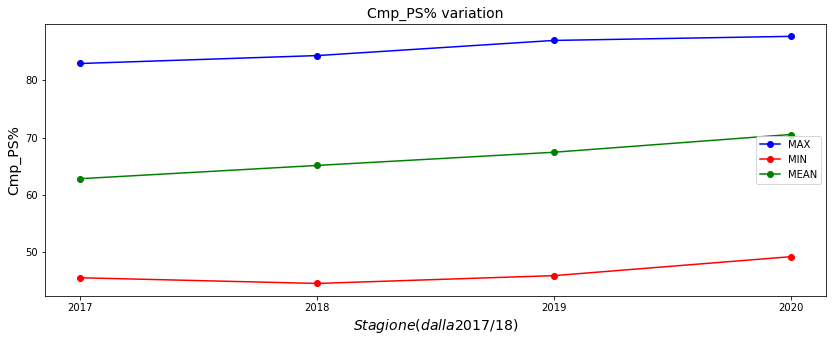

In [72]:
cfr_anni(dict_, "Cmp_PS%")

Notiamo un aumento costante del valore medio di $\textit{Cmp_PS%}$ nei vari anni, dovuto alla crescente tendenza alla costruzione dal basso. Quest'incremento si nota sia nei portieri maggiormente dotati da questo punto di vista (valori massimi) che nei portieri meno abili coi piedi (valori minimi).

Questo dato può essere interpretato da due punti di vista: da un lato, la tendenza a giocare con passaggi brevi, che è in aumento negli ultimi anni, ha fatto aumentare l'accuratezza (banalmente, è molto più probabile sbagliare un passaggio lungo e alto piuttosto che un passaggio corto e rasoterra); dall'altro, i portieri sono sempre più stimolati ed allenati sotto questo aspetto, con un naturale beneficio in termini di precisione. È quindi evidente che qualunque squadra e qualunque portiere, anche chi non fa di questa caratteristica il proprio cavallo di battaglia (valori minimi) abbiano cercato di migliorare questo fondamentale.

<h4>Analisi Stp%</h4>

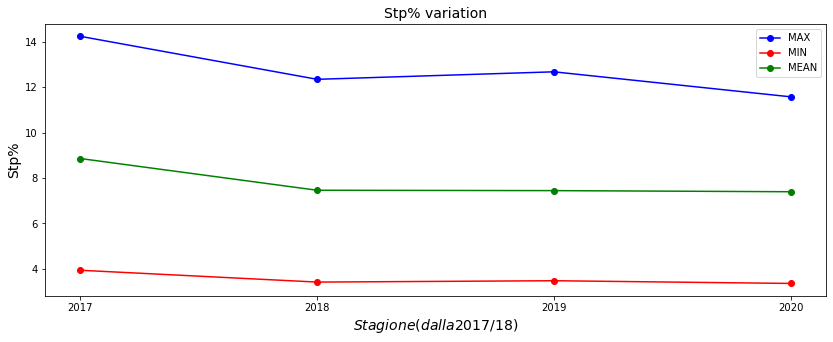

In [73]:
cfr_anni(dict_, "Stp%")

Per quanto riguarda $ \textit{Stp%} $, l'andamento osservato è decrescente per i valori massimi (in blu), per i valori minimi (in rosso) e per la media. Questo è probabilmente dovuto al fatto che negli ultimi anni si tende meno a crossare verso l'area piccola dove è più facile uscire per un portiere, e più verso il dischetto o il limite dell'area, zone troppo lontane per consentire l'intervento del portiere. Se questa tendenza verrà confermata, probabilmente l'abilità nelle uscite sarà sempre meno importante in futuro.


<h2>Variazione cluster di appartenenza</h2>

Prendiamo in esame un portiere che potrebbe aver cambiato cluster nell'arco temporale analizzato e analizziamo questa variazione. 

Prendiamo in esame il portiere del Paris Saint Germain **Keylor Navas**.

In [74]:
giocatore = "Keylor Navas"

Determiniamo il cluster di appartenenza per ogni anno

In [75]:
kmeans_DEF.predict([d["dt_gk_2017"][['/90', 'Cmp_PS%', 'Stp%', 'Age']].loc[giocatore]])

array([1], dtype=int32)

In [76]:
kmeans_DEF.predict([d["dt_gk_2018"][['/90', 'Cmp_PS%', 'Stp%', 'Age']].loc[giocatore]])

array([1], dtype=int32)

In [77]:
kmeans_DEF.predict([d["dt_gk_2019"][['/90', 'Cmp_PS%', 'Stp%', 'Age']].loc[giocatore]])

array([2], dtype=int32)

In [78]:
kmeans_DEF.predict([d["dt_gk_2020"][['/90', 'Cmp_PS%', 'Stp%', 'Age']].loc[giocatore]])

array([2], dtype=int32)

Verifichiamo se le stesse variazioni di classe sono riconosciute anche dal classsificatore definito in precedenza.

In [79]:
dt_navas = pd.DataFrame(index=date, columns=['/90', 'Cmp_PS%', 'Stp%', 'Age'])
i = 0;
for c in dict_.keys():
    dt_navas.iloc[i]  = dict_[c].loc[giocatore][['/90', 'Cmp_PS%', 'Stp%', 'Age']]
    i+= 1
dt_navas

/90 Cmp_PS%  Stp% Age
2017  0.14    78.9  10.2  30
2018  0.07    78.2   7.6  31
2019 -0.08      86   6.3  32
2020  0.14    87.2   3.5  33

In [80]:
clus = []
for i in range(4):
    clus.append(clf.predict([dt_navas.iloc[i]]))
    
clus

[array([1], dtype=int32),
 array([1], dtype=int32),
 array([2], dtype=int32),
 array([2], dtype=int32)]

In [81]:
clust_ = pd.DataFrame(data=clus, index=["2017", "2018", "2019", "2020"], columns = {"cluster"})


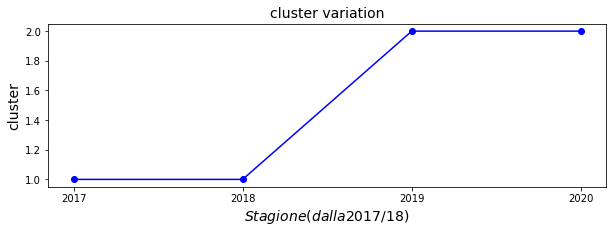

In [82]:
plt.figure(figsize=(10, 3))
plt.plot( clust_, "bo-")
plt.xlabel("$Stagione (dalla 2017/18)$", fontsize=14)
plt.ylabel("cluster", fontsize=14)
plt.title("cluster variation", fontsize=14)
plt.show()

Notiamo che **Keylor Navas** ha cambiato cluster tra la stagione 2017/18 e quella 2020/21:

- nelle stagioni 2017/2018 e 2018/2019 Keylor Navas era nel $\textit{prime}$ della sua carriera, conquistava la UCL con il Real Madrid. Apparteneva al cluster dei $ \textit{portieri moderni}$ (cluster 1) con una buona abilità con i piedi, nelle uscite sui cross e con un valore positivo di $ /90 $, ad indicare la sua abilità tra i pali.
- nelle stagioni 2019/2020 e 2020/2021, coincidenti con il suo passaggio al Paris Saint Germain, Keylor Navas ha iniziato una fase calante della sua carriera; è stato infatti spostato nel cluster degli $ \textit{ex-campioni}$ (cluster 2) caratterizzati da una buona capacità con i piedi ma una bassa capacità nelle uscite sui cross e da un età avanzata.

Plottiamo l'andamento delle varie statistiche del giocatore anno per anno

[Text(0, 0.5, 'Stp%'), Text(0.5, 0, '$Stagione (dalla 2017/18)$')]

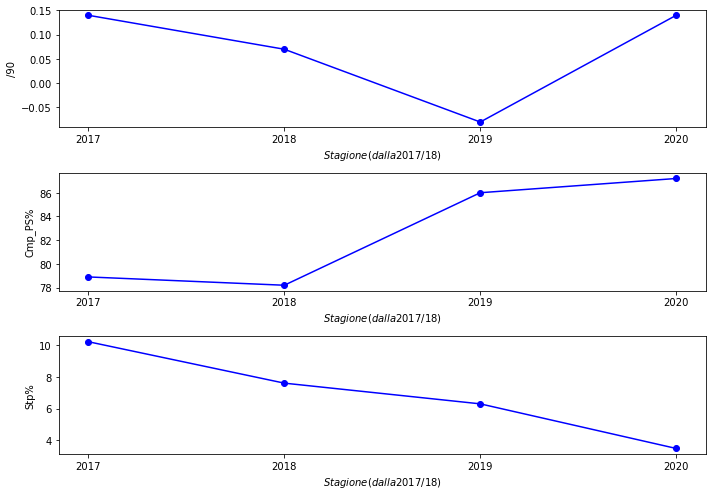

In [83]:
fig, axis = plt.subplots(3 ,tight_layout=True)
fig.set_size_inches(10, 7)

axis[0].plot(dt_navas["/90"], "bo-")
axis[0].set(xlabel="$Stagione (dalla 2017/18)$", ylabel= "{}".format("/90"))

axis[1].plot(dt_navas["Cmp_PS%"], "bo-")
axis[1].set(xlabel="$Stagione (dalla 2017/18)$", ylabel= "{}".format("Cmp_PS%"))

axis[2].plot(dt_navas["Stp%"], "bo-")
axis[2].set(xlabel="$Stagione (dalla 2017/18)$", ylabel= "{}".format("Stp%"))

La descrescita di $\textit{Stp%}$ è dovuta a due fattori principali:
1. il trend decrescente evidenziato prima, dovuto al fatto che negli ultimi anni si tende meno a crossare verso l'area piccola;
2. l'avanzamento dell'età, con conseguente perdita di esplosività e reattività.

Si nota un calo di $ \textit{/90} $ nel $2019$. Notiamo invece un andamento crescente di $\textit{Cmp_PS%}$ dovuto all'aumento della tendenza alla costruzione dal basso delle squadre ed al trasferimento al PSG con conseguente cambiamento nello stile di gioco.

In conclusione, possiamo affermare che l'acquisto di Donnarumma sia stata una scelta adatta e lungimirante da parte del PSG, visto il cambiamento di cluster e l'auspicabile e già avviato calo di Navas, che si avvia alla conclusione della sua carriera.